In [1]:
from math import ceil
from pathlib import Path
import pandas as pd
from fastai.vision import *
from efficientnet_pytorch import EfficientNet


def read_train_val_indices(train_indices_path, val_indices_path, image_root_dir=None):
    train_df = pd.read_csv(train_indices_path, header=None, sep=" ", names=["name", "label"])
    val_df = pd.read_csv(val_indices_path, header=None, sep=" ", names=["name", "label"])
    train_df['is_valid'] = False
    val_df['is_valid'] = True
    trainval_df = pd.concat([train_df, val_df])
    if image_root_dir is not None:
        trainval_df.loc[:, "name"] = trainval_df.name.apply(lambda x: Path(x).relative_to(image_root_dir))
    return trainval_df


image_root_dir = Path("/data2/datasets/clobotics/ccth/images/cropped/versions/train20200129_val20200117_test20191122")
train_indices = Path("/data2/datasets/clobotics/ccth/indices/versions/train20200129_val20200117_test20191122/subbrand-classification/train.txt")
val_indices = Path("/data2/datasets/clobotics/ccth/indices/versions/train20200129_val20200117_test20191122/subbrand-classification/val.txt")
n_max_epochs = 10
batch_size = 24
max_lr = 9e-4
tfms = get_transforms(
    do_flip=True,  # default True
    flip_vert=False,  # default False
    max_rotate=10.0,  # default 10.0
    max_zoom=1.1,  # default 1.1
    max_lighting=0.2,  # default 0.2
    max_warp=0.2,  # default 0.2
    p_affine=0.75,  # default 0.75
    p_lighting=0.75,  # default 0.75
)

dataset = read_train_val_indices(train_indices, val_indices, image_root_dir=image_root_dir)

data_bunch = ImageList \
    .from_df(dataset, image_root_dir) \
    .split_from_df() \
    .label_from_df() \
    .transform(tfms, size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros') \
    .databunch(bs=batch_size, num_workers=4) \
    .normalize(imagenet_stats)

model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=197)
learn = Learner(data_bunch, model, metrics=accuracy, path="/home/rlan/deploy/ccth/checkpoints/subbrand-init")

Loaded pretrained weights for efficientnet-b5


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 4.79E-03


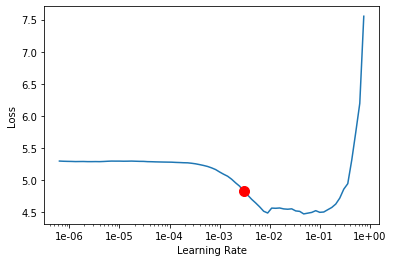

In [2]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [3]:
learn.recorder.min_grad_lr

0.0030199517204020187